# Bank Customer Churn

## Objective

In this notebook, we will explore the 'Bank Customer Churn' dataset to analyze customer churn and extract valuable information. This information will help the bank improve its customer retention strategies. Afterward, we will attempt to build a model for predicting customer churn.

Customer churn refers to the occurrence when customers discontinue their relationship with a company or stop using its products or services. Understanding the factors that contribute to churn is crucial for businesses to retain customers and maintain long-term profitability. As we know, it is much more expensive to sign in a new client than keeping an existing one. It is advantageous for banks to know what leads a client towards the decision to leave the company. Churn prevention allows companies to develop loyalty programs and retention campaigns to keep as many customers as possible.

## Data Dictionary

**RowNumber:** The unique identifier for each record in the dataset<br>
**CustomerId:** Randomly generated values assigned to each customer<br>
**Surname:** The last name of the customer<br>
**CreditScore:** A measure of the customer's creditworthiness<br>
**Geography:** The customer's location<br>
**Gender:** The customer's gender<br>
**Age:** The customer's age<br>
**Tenure:** The number of years the customer has been a client of the bank, indicating loyalty.<br>
**Balance:** The amount of money in the customer's account<br>
**NumOfProducts:** The number of products the customer has purchased through the bank.<br>
**HasCrCard:** Indicates whether the customer has a credit card.<br>
**IsActiveMember:** Indicates whether the customer is an active member.<br>
**EstimatedSalary:** The estimated salary of the customer, which, similar to balance.<br>
**Exited:** Indicates whether the customer has left the bank or not, indicating whether a customer has churned (1) or not (0)<br>
**Complain:** Indicates whether the customer has made a complaint or not.<br>
**SatisfactionScore:** The score provided by the customer for the resolution of their complaint.<br>
**CardType:** The type of card held by the customer.<br>
**Points Earned:** The points earned by the customer for using their credit card.

## Table of Contents

* [Basic Data Exploration](#Basic-Data-Exploration)
* [Data Preprocessing and Feature Engineering](#Data-Preprocessing-and-Feature-Engineering)
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
* [Model Building](#Model-Building)
* [More Feature Engineering](#Feature-Engineering)
* [Conclusion](#Conclusion)

In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Feature Engineering
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import mstats # Winsorization

# Model
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### Basic Data Exploration

In [2]:
df = pd.read_csv('C:/Users/ALEX/Desktop/Project/Bank Customer Churn/Dataset/Bank_Customer_Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


We will remove a few features that will not impact our analysis and model.

In [3]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [4]:
# The dataset contains 10,000 rows and 15 columns
df.shape

(10000, 15)

In [5]:
# All of our columns have no missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         10000 non-null  int64  
 1   Geography           10000 non-null  object 
 2   Gender              10000 non-null  object 
 3   Age                 10000 non-null  int64  
 4   Tenure              10000 non-null  int64  
 5   Balance             10000 non-null  float64
 6   NumOfProducts       10000 non-null  int64  
 7   HasCrCard           10000 non-null  int64  
 8   IsActiveMember      10000 non-null  int64  
 9   EstimatedSalary     10000 non-null  float64
 10  Exited              10000 non-null  int64  
 11  Complain            10000 non-null  int64  
 12  Satisfaction Score  10000 non-null  int64  
 13  Card Type           10000 non-null  object 
 14  Point Earned        10000 non-null  int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 1.1+

In [6]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800,0.204400,3.013800,606.515100
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842,0.403283,1.405919,225.924839
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,1.000000,119.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,2.000000,410.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,3.000000,605.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,0.000000,4.000000,801.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,5.000000,1000.000000


**Dependent Variable**

The churn rate is 20.38%, which is pretty high.

In [7]:
df['Exited'].value_counts()

0    7962
1    2038
Name: Exited, dtype: int64

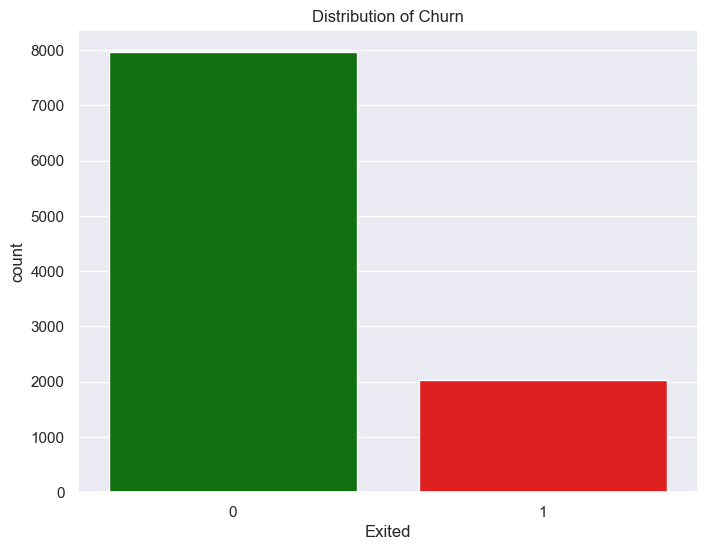

In [8]:
sns.set(style="darkgrid", palette=["green", "red"])

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.countplot(x='Exited', data=df)
plt.title('Distribution of Churn')

# Display the plot
plt.show()

**Categorical and Numerical Features**

In [9]:
# Select the categorical features
categorical_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Complain', 'CardType']

# Select the numerical features
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary',
                      'SatisfactionScore', 'PointEarned']

# Count the number of categorical and numerical features
count_categorical = len(categorical_features)
count_numerical = len(numerical_features)

# Print the counts
print("Number of categorical features:", count_categorical)
print("Number of numerical features:", count_numerical)

Number of categorical features: 6
Number of numerical features: 8


### Data Preprocessing and Feature Engineering

**Checking if there are any duplicate rows.**

In [10]:
# Check for duplicate rows in the dataframe
duplicates = df.duplicated()

# Check if any duplicates exist
if duplicates.any():
    # Count the number of duplicate rows
    num_duplicates = duplicates.sum()
    print(f"The dataset has {num_duplicates} duplicate rows.")
else:
    print("The dataset does not have any duplicate rows.")


The dataset does not have any duplicate rows.


**Trim whitspace on feature names**

For consistency, we will trim whitespaces in the feature names of 'Satisfaction Score', 'Card Type', and 'Point Earned'.

In [11]:
df = df.rename(columns={
    'Satisfaction Score': 'SatisfactionScore',
    'Card Type': 'CardType',
    'Point Earned': 'PointEarned'
})

**Outliers**

We have identified outliers in the 'CreditScore' and 'Age' columns. To address this, we will apply a log transformation. Additionally, we will use the winsorization technique to cap the outliers in the 'CreditScore' and 'Age' columns.

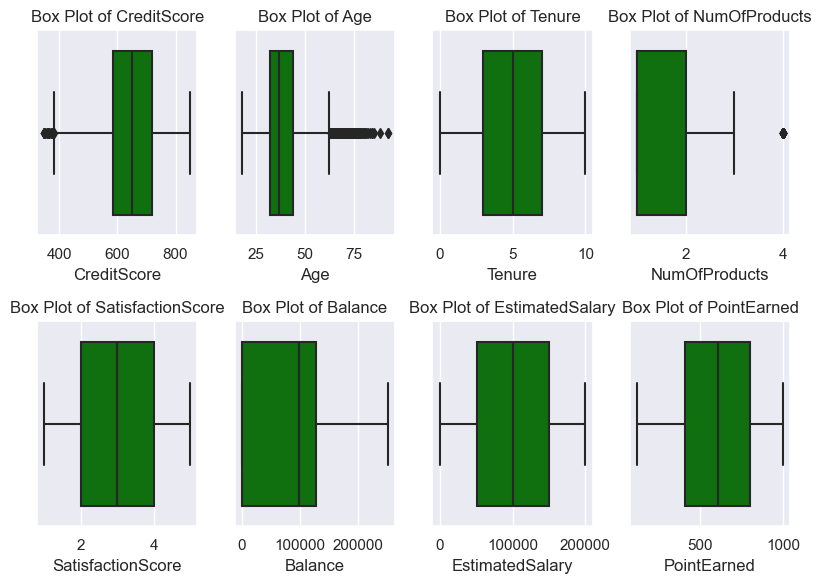

In [12]:
features = ['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'SatisfactionScore', 'Balance', 'EstimatedSalary', 'PointEarned']

# Create individual box plots for each feature
plt.figure(figsize=(8, 6))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=feature, data=df)
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()

The outliers make the distribution of 'CreditScore' and 'Age' skewed. Therefore, we will apply a log transformation to these features.

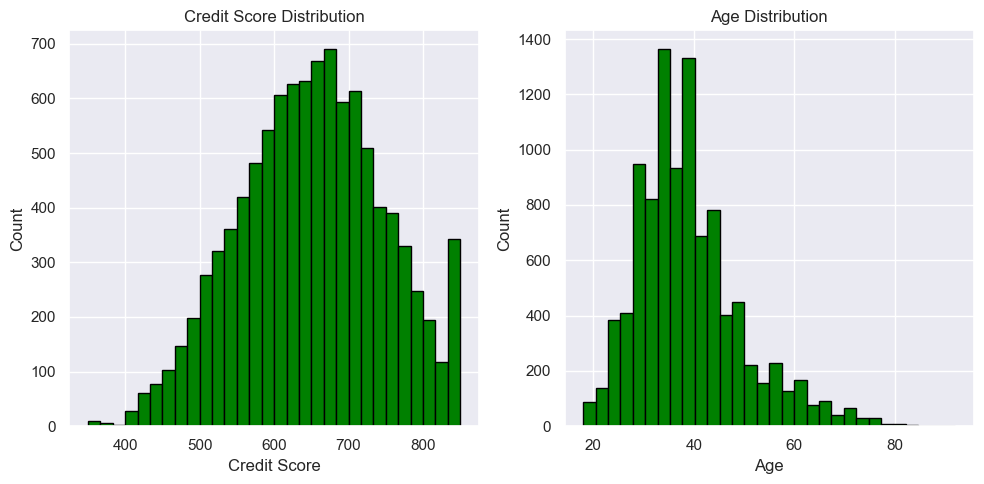

In [13]:
# Plotting the CreditScore distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(df['CreditScore'], bins=30, edgecolor='black')
plt.xlabel('Credit Score')
plt.ylabel('Count')
plt.title('Credit Score Distribution')

# Plotting the Age distribution
plt.subplot(1, 2, 2)
plt.hist(df['Age'], bins=30, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')

plt.tight_layout()
plt.show()

**Log Transformation**

We will apply a log transformation to mitigate the impact of outliers.

In [14]:
# Applying log transformation to the CreditScore and Age features
df['CreditScore_log'] = np.log(df['CreditScore'])
df['Age_log'] = np.log(df['Age'])

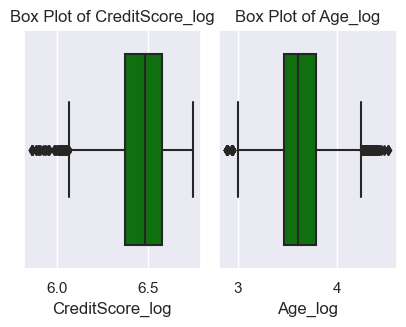

In [15]:
features = ['CreditScore_log', 'Age_log']

# Create individual box plots for each feature
plt.figure(figsize=(8, 6))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=feature, data=df)
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()

The 'Age' distribution is better now, but the 'CreditScore' distribution remains slightly left-skewed.

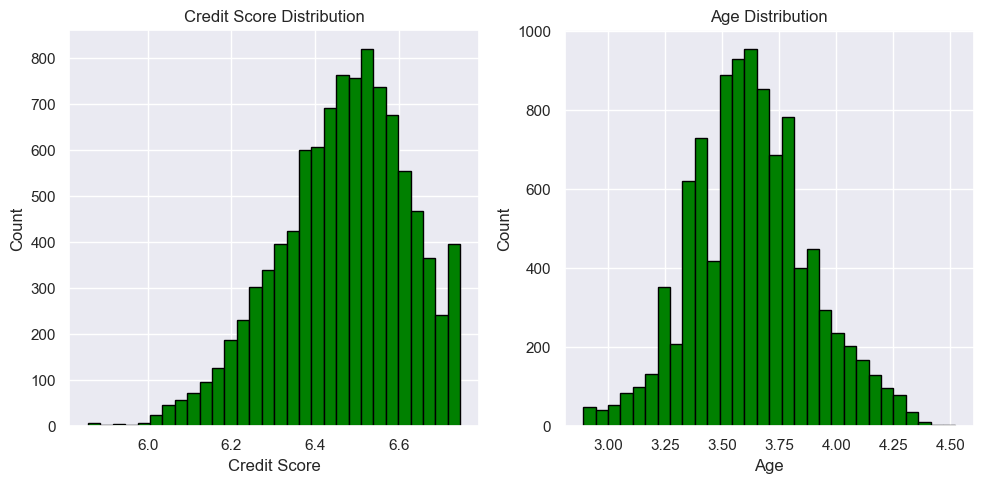

In [16]:
# Plotting the CreditScore distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(df['CreditScore_log'], bins=30, edgecolor='black')
plt.xlabel('Credit Score')
plt.ylabel('Count')
plt.title('Credit Score Distribution')

# Plotting the Age distribution
plt.subplot(1, 2, 2)
plt.hist(df['Age_log'], bins=30, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')

plt.tight_layout()
plt.show()

**Winsorization**

We will apply winsorization to eliminate the outliers by replacing them with the values at a specific percentile.

In [17]:
# Set the percentile values for winsorization
lower_percentile = 0.01
upper_percentile = 0.98

# Apply winsorization to the 'CreditScore' column
df['CreditScore_log'] = mstats.winsorize(df['CreditScore_log'], limits=[lower_percentile, 1-upper_percentile])

# Apply winsorization to the 'Age' column
df['Age_log'] = mstats.winsorize(df['Age_log'], limits=[lower_percentile, 1-upper_percentile])

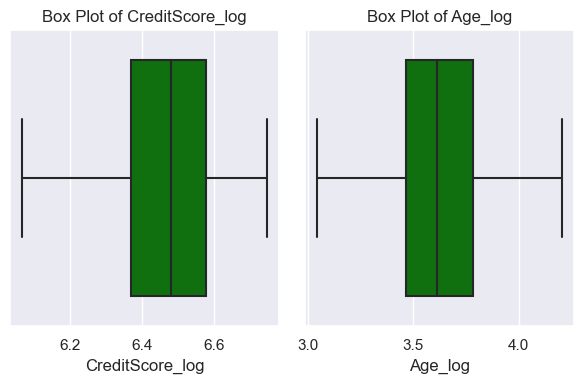

In [18]:
features = ['CreditScore_log', 'Age_log']

# Create individual box plots for each feature
plt.figure(figsize=(6, 4))
for i, feature in enumerate(features, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(x=feature, data=df)
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()

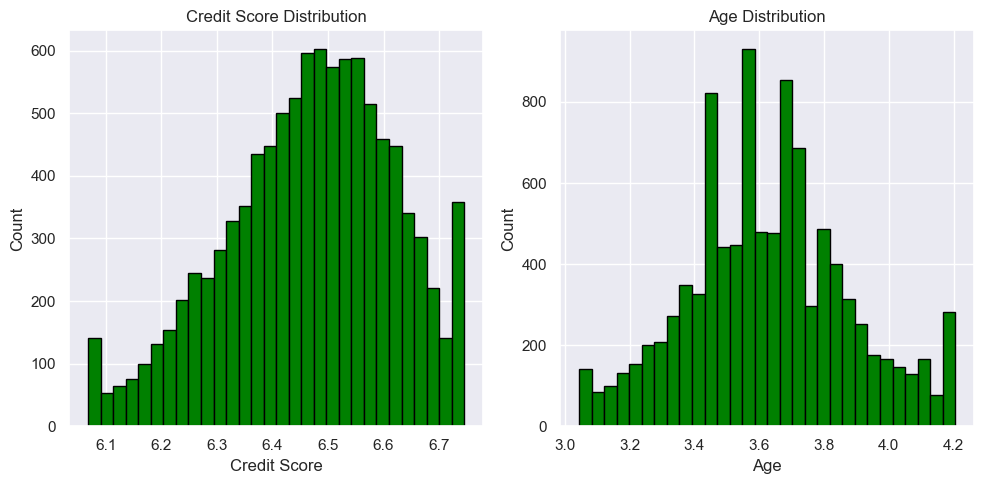

In [19]:
# Plotting the CreditScore distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(df['CreditScore_log'], bins=30, edgecolor='black')
plt.xlabel('Credit Score')
plt.ylabel('Count')
plt.title('Credit Score Distribution')

# Plotting the Age distribution
plt.subplot(1, 2, 2)
plt.hist(df['Age_log'], bins=30, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')

plt.tight_layout()
plt.show()

**Preprocessing Pipeline**

The pipeline steps:
- Split the dataframe into X for the features and y for the target variable
- Separate the numerical and categorical columns and define the remaining columns that will not go through the pipeline ('IsActiveMember', 'HasCrCard') because they are already encoded
- Create transformers for scaling the numerical columns and apply one-hot encoding and ordinal encoding for the categorical columns
- Combine the transformers and columns into a 'preprocessor'
- Finally, fit and apply the 'preprocessor' to X to obtain the preprocessed features, X_preprocessed.

In [20]:
# Split the dataframe into features (X) and target (y)
# We exclude the 'Complain' column to prevent overfitting. Further explanation can be found in the correlation matrix section below.
# We exclude the 'Age' and 'CreditScore' columns because we have performed a log transformation to create new features.
X = df.drop(['Exited', 'Complain', 'Age', 'CreditScore'], axis=1)
y = df['Exited']

# Select numerical and categorical columns
numerical_columns = ['CreditScore_log', 'Age_log', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'PointEarned']
categorical_one_hot_columns = ['Geography', 'Gender', 'CardType']
categorical_ordinal_columns = ['SatisfactionScore']

# Define the remaining columns
remaining_columns = list(set(X.columns) - set(numerical_columns) - set(categorical_one_hot_columns) - set(categorical_ordinal_columns))

# Create transformers
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_one_hot_transformer = Pipeline(steps=[('encoder', OneHotEncoder())])
ordinal_transformer = Pipeline(steps=[('ordinal_encoder', OrdinalEncoder())])
remaining_transformer = 'passthrough'

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('one_hot', categorical_one_hot_transformer, categorical_one_hot_columns),
        ('ordinal', ordinal_transformer, categorical_ordinal_columns),
        ('remaining', remaining_transformer, remaining_columns)]
)

# Apply preprocessing to X
X_preprocessed = preprocessor.fit_transform(X)

**Checking if all of our features correctly preprocessed**

In [21]:
# Get the column names after preprocessing
categorical_encoded_columns = preprocessor.named_transformers_['one_hot'].named_steps['encoder'].get_feature_names_out(categorical_one_hot_columns)
all_columns = numerical_columns + list(categorical_encoded_columns) + categorical_ordinal_columns + remaining_columns

# Create a DataFrame using X_preprocessed and column names
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_columns)

X_preprocessed_df.head()

,CreditScore_log,Age_log,Tenure,Balance,NumOfProducts,EstimatedSalary,PointEarned,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,CardType_DIAMOND,CardType_GOLD,CardType_PLATINUM,CardType_SILVER,SatisfactionScore,IsActiveMember,HasCrCard
0,-0.255613,0.439362,-1.041760,-1.225848,-0.911583,0.021886,-0.630839,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
1,-0.373896,0.343857,-1.387538,0.117350,-0.911583,0.216534,-0.666251,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0
2,-1.637677,0.439362,1.032908,1.333053,2.527057,0.240687,-1.015942,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0
3,0.546198,0.145654,-1.387538,-1.225848,0.807737,-0.108918,-1.135457,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0
4,1.836437,0.532619,-1.041760,0.785728,-0.911583,-0.365276,-0.803472,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,1.0,1.0


**Split the preprocessed data into train and test sets**

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

**Imbalanced Dataset**

We have an imbalanced dataset, with the class we want to predict (1) being significantly less represented than (0). This class imbalance can affect our model, so we need to address it by utilizing a random oversampler. **We will use random oversampler only for training data**.

In [23]:
# Calculate the sum of the number of data points in X_train and y_train
total_samples = X_train.shape[0] + len(y_train)

# Count the number of data points in y_train for each class
class_counts = y_train.value_counts()

# Print the sum of the number of data points in X_train and y_train
print("Sum of the number of data points in X_train and y_train:", total_samples)

# Print the counts for each class
print("Class distribution in y_train:")
print(class_counts)

Sum of the number of data points in X_train and y_train: 16000
Class distribution in y_train:
0    6355
1    1645
Name: Exited, dtype: int64


In [24]:
ros = RandomOverSampler(random_state=42)

# Resample the data
X_train, y_train = ros.fit_resample(X_train, y_train)

In [25]:
# Calculate the sum of the number of data points in X_train and y_train
total_samples = X_train.shape[0] + len(y_train)

# Count the number of data points in y_train for each class
class_counts = y_train.value_counts()

# Print the sum of the number of data points in X_train and y_train
print("Sum of the number of data points in X_train and y_train after applying oversampler:", total_samples)

# Print the counts for each class
print("Class distribution in y_train after applying oversampler:")
print(class_counts)

Sum of the number of data points in X_train and y_train after applying oversampler: 25420
Class distribution in y_train after applying oversampler:
0    6355
1    6355
Name: Exited, dtype: int64


### Exploratory Data Analysis

In [26]:
# Select the categorical features
categorical_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Complain', 'CardType']

# Select the numerical features
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary',
                      'SatisfactionScore', 'PointEarned']

**Categorical features distribution**

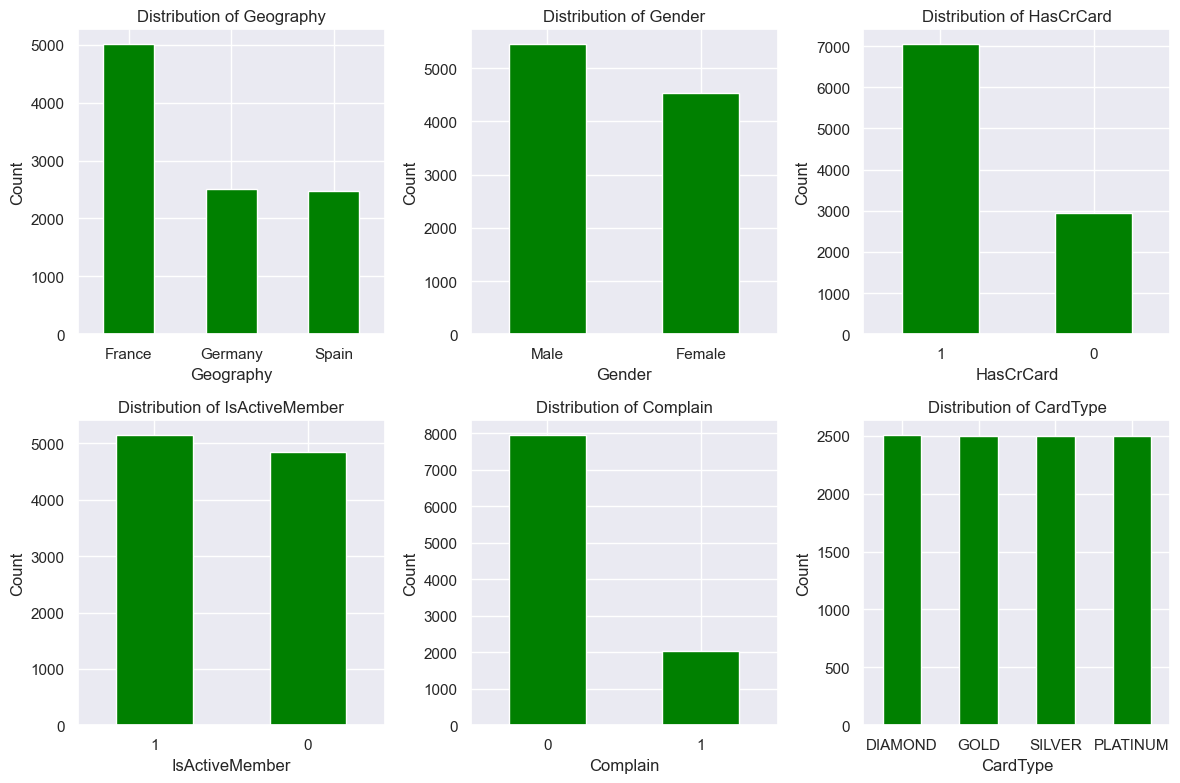

In [27]:
# Define the number of columns and rows for the subplots
num_cols = 3  # Number of columns in the grid
num_rows = (len(categorical_features) + num_cols - 1) // num_cols  # Calculate the number of rows based on the feature count

# Create a new figure and axis objects for the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Flatten the axs array if the number of features is less than num_cols x num_rows
axs = axs.flatten()

# Iterate over each categorical feature and create the subplot
for i, feature in enumerate(categorical_features):
    # Create a bar plot of feature distribution
    df[feature].value_counts().plot(kind='bar', ax=axs[i])
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Count')
    axs[i].tick_params(axis='x', rotation=0)  # Rotate x-labels
    
plt.tight_layout()  # Adjust the spacing between subplots

plt.show()

**Numerical features distribution**


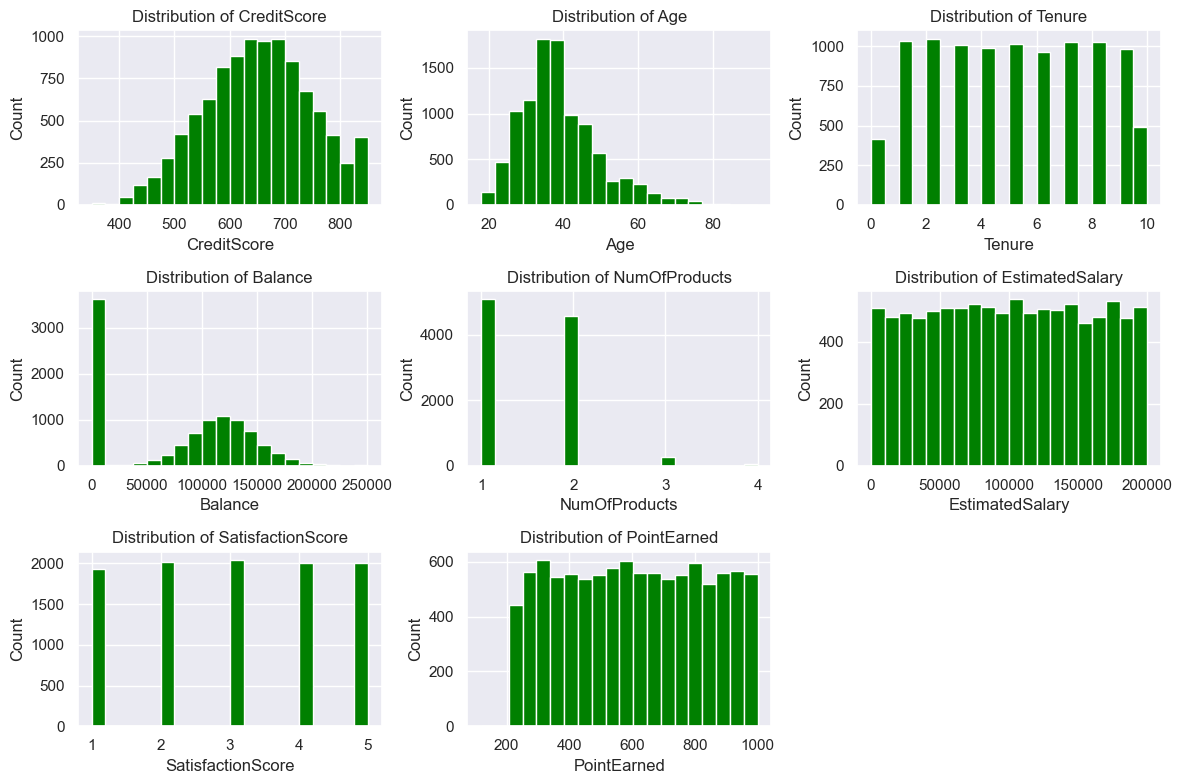

In [28]:
# Define the number of columns and rows for the subplots
num_cols = 3  # Number of columns in the grid
num_rows = (len(numerical_features) + num_cols - 1) // num_cols  # Calculate the number of rows based on the feature count

# Create a new figure and axis objects for the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Flatten the axs array if the number of features is less than num_cols x num_rows
axs = axs.flatten()

# Iterate over each numerical feature and create the subplot
for i, feature in enumerate(numerical_features):
    # Create a histogram of feature distribution
    axs[i].hist(df[feature], bins=20)  # Adjust the number of bins as needed
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Count')
    
# Hide any empty subplots
for j in range(len(numerical_features), num_cols * num_rows):
    axs[j].axis('off')
    
plt.tight_layout()  # Adjust the spacing between subplots

plt.show()

**Churn by categorial features**

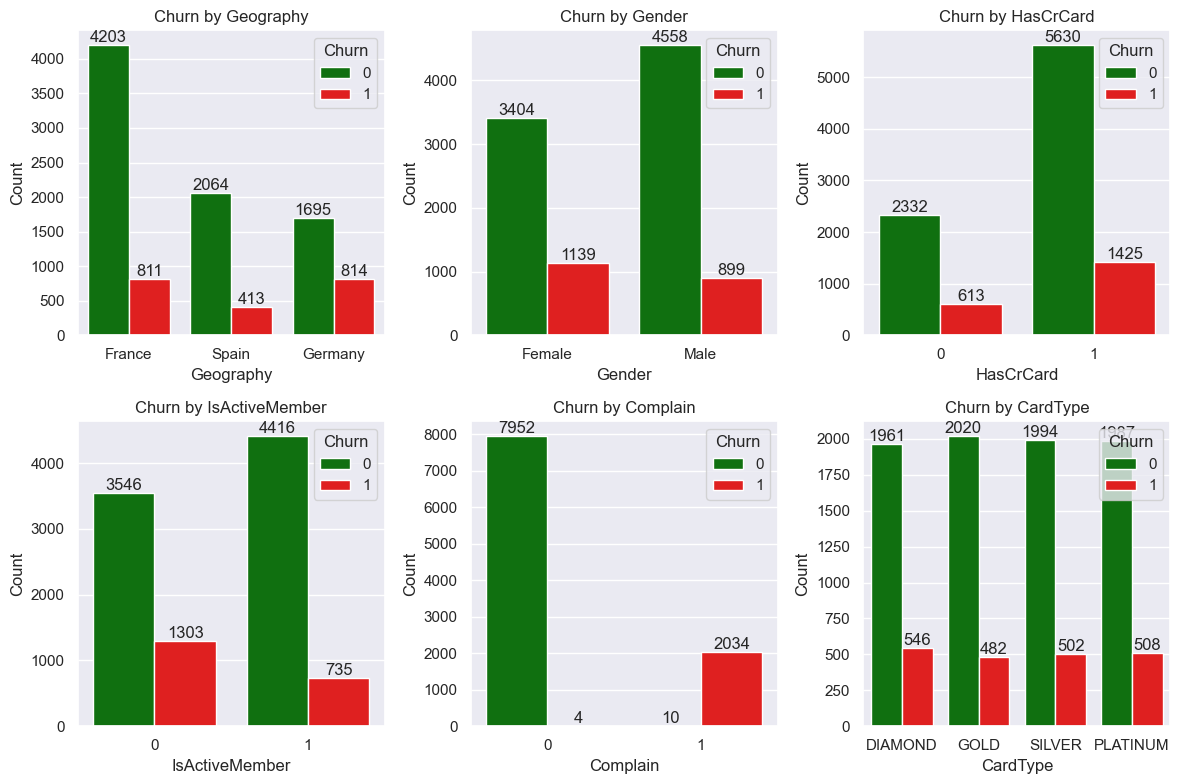

In [29]:
# Define the number of columns and rows for the subplots
num_cols = 3  # Number of columns in the grid
num_rows = (len(categorical_features) + num_cols - 1) // num_cols  # Calculate the number of rows based on the feature count

# Create a new figure and axis objects for the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Flatten the axs array if the number of features is less than num_cols x num_rows
axs = axs.flatten()

# Iterate over each categorical feature and create the subplot
for i, feature in enumerate(categorical_features):
    # Create a bar plot of feature distribution
    sns.countplot(data=df, x=feature, hue="Exited", ax=axs[i])
    axs[i].set_title(f'Churn by {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Count')
    axs[i].tick_params(axis='x', rotation=0)  # Rotate x-labels
    
    # Update legend title
    legend = axs[i].legend()
    legend.set_title('Churn')
    
    # Add count labels on top of each bar
    for p in axs[i].patches:
        height = p.get_height()
        axs[i].annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')
    
plt.tight_layout()  # Adjust the spacing between subplots

plt.show()

**Churn by Geography**

The churn rate in Germany is higher than in other countries.

---

**Churn by Gender**

The churn rate of females is slightly higher than males

---

**Churn by HasCrCard**

The churn rate is similar whether customers have a credit card or not.

---

**Churn by IsActiveMember**

Non-active members have a slightly higher churn rate than active members.

---

**Churn by Complain**

There is an unusual relationship between customer complaints and churn. Those who make a complaint have a 99% churn rate, while those who do not make a complaint have a 99% retention rate. This could indicate poor customer service from the bank in handling complaints. **This relationship may affect our model**, so we will address it later.

---

**Churn by CardType**

There is no difference in churn rate among customers with silver, gold, platinum, or diamond card types.

---

**Churn by Numerical Features**

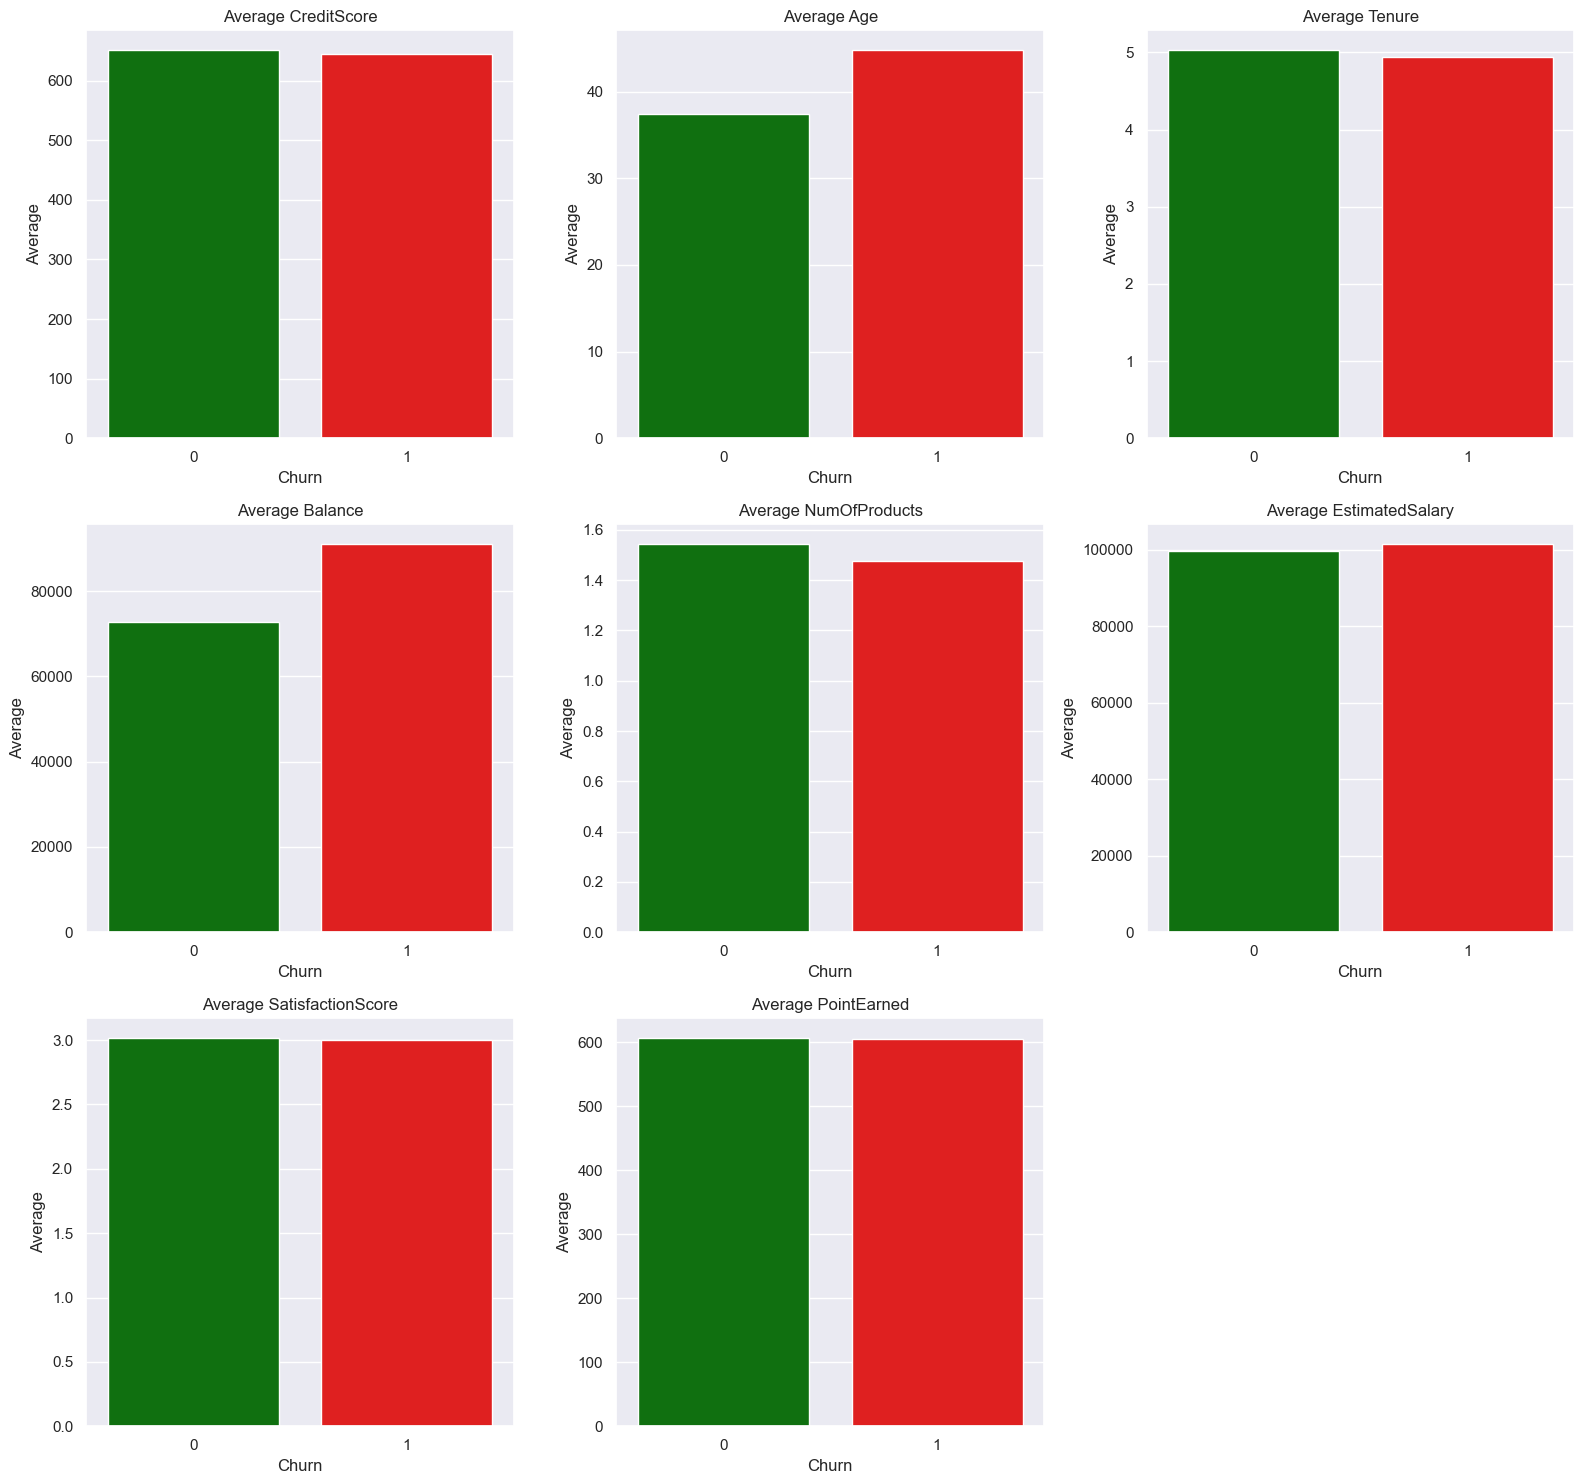

In [30]:
# Group the data by 'Exited' and calculate the average for each numerical feature
average_data = df.groupby('Exited')[numerical_features].mean().reset_index()

# Determine the number of rows and columns for the subplots
num_features = len(numerical_features)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols

# Set up the figure and axis objects
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 5 * num_rows))

# Flatten the axs array if necessary
axs = axs.flatten()

# Iterate over each numerical feature and create the bar plot
for i, feature in enumerate(numerical_features):
    ax = axs[i]
    sns.barplot(x='Exited', y=feature, data=average_data, ax=ax)
    ax.set_title(f'Average {feature}')
    ax.set_xlabel('Churn')
    ax.set_ylabel('Average')

# Hide any extra subplots
for j in range(num_features, num_rows * num_cols):
    axs[j].axis('off')

plt.tight_layout()  # Adjust the spacing between subplots

plt.show()

**Churn by Average CreditScore**

The people who churned and those who do not churn have a similar average credit score.

---

**Churn by Average Age**

The people who churned have a higher average age than those who did not churn.

---

**Churn by Average Tenure**

The people who churned and those who did not churn have a similar average tenure. Tenure is an indicator of loyalty, and the average tenure for those who churned is around 5 years. This is concerning because the bank should prioritize retaining customers with longer tenure in order to prevent them from churning.

---

**Churn by Average Balance**

Surprisingly, the average balance of people who churned is higher than that of those who did not churn. This finding may require further investigation or consultation with stakeholders to understand the reasons behind this occurrence.

---

**Churn by Average NumOfProducts**

The people who churned and those who do not churn have a similar average number of products.

---

**Churn by Average EstimatedSalary**

The people who churned and those who do not churn have a similar average estimated salary.

---

**Churn by Average Satisfaction**

The people who churned and those who did not churn have a similar average satisfaction score. Satisfaction score indicates the rating provided by customers for the resolution of their complaints. Interestingly, customers who raised complaints gave an average satisfaction score of 3, and 50% of them eventually churned. This could indicate poor customer service from the bank in handling complaints, highlighting the need for improvement.

---

**Churn by Average PointEarned**

The people who churned and those who do not churn have a similar average point earned.

---

**Correlation Matrix**

The correlation between 'Complain' and the target variable 'Exited' is 1, indicating a perfect correlation. Perfect correlation between a feature and the target variable can potentially lead to overfitting, which occurs when the model is overly trained. Therefore, we need to remove the 'Complain' column to avoid overfitting.

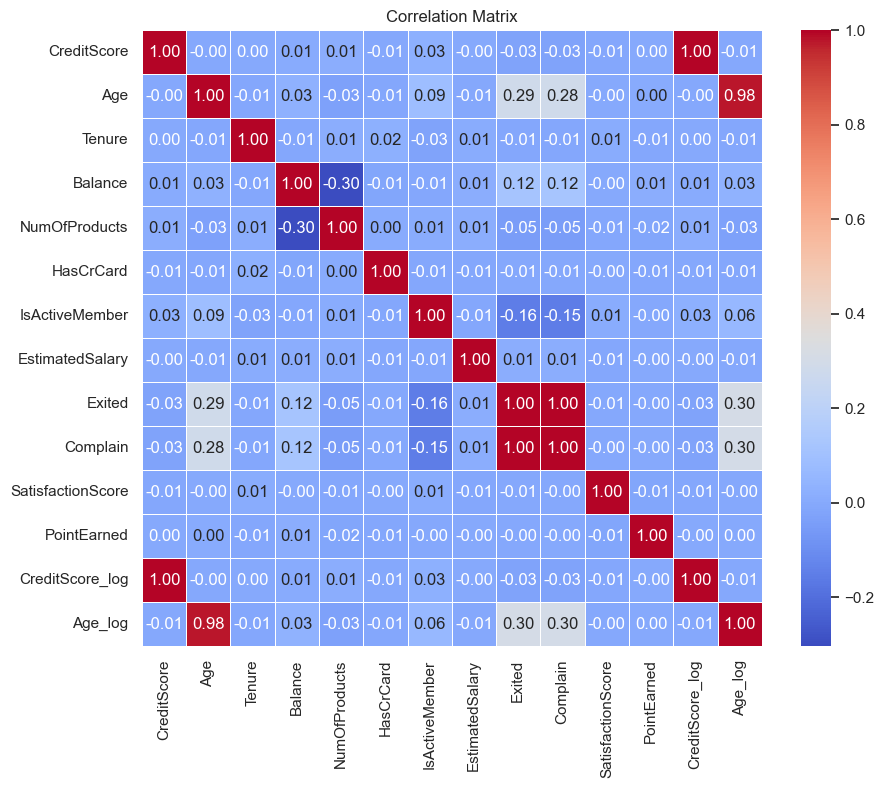

In [31]:
corr_matrix = df.corr(numeric_only=True)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Create the correlation plot
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, ax=ax)

# Customize the plot
ax.set_title("Correlation Matrix")

# Show the plot
plt.show()

### Model Building

This code sets up a framework for comparing the performance of multiple machine learning models using cross-validation and evaluating them on a test set.

In [32]:
# Create a dictionary of models
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier()
}

# Perform cross-validation for each model
for model_name, model in models.items():
    print("Model:", model_name)
    
    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=3)
    print("Cross-validation scores:", scores)
    
    # Fit the model on the entire training set
    model.fit(X_train, y_train)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    
    # Print the classification report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    print("---------------------------------------------------\n")

Model: Naive Bayes
Cross-validation scores: [0.70427189 0.7132405  0.72355996]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.74      0.81      1607
           1       0.39      0.70      0.50       393

    accuracy                           0.73      2000
   macro avg       0.65      0.72      0.66      2000
weighted avg       0.81      0.73      0.75      2000

---------------------------------------------------

Model: Logistic Regression
Cross-validation scores: [0.69317914 0.71206042 0.71340888]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.71      0.80      1607
           1       0.38      0.73      0.50       393

    accuracy                           0.71      2000
   macro avg       0.65      0.72      0.65      2000
weighted avg       0.81      0.71      0.74      2000

---------------------------------------------------

Model: Random Forest
Cross

In this code, we perform hyperparameter tuning for each model using grid search with cross-validation. Through systematic evaluation of various combinations of hyperparameters, this approach helps us identify the optimal set of hyperparameters for each model. However, we did not observe any significant improvement in this case.

In [33]:
# Create a dictionary of models
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier()
}

# Create a dictionary of parameter grids for grid search
param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 5],
        'min_samples_split': [2, 5]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'KNN': {
        'n_neighbors': [1, 3, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3]
    },
    'Naive Bayes': {}
}

# Perform grid search and cross-validation for each model
for model_name, model in models.items():
    print("Model:", model_name)
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(model, param_grid, cv=3)
    grid_search.fit(X_train, y_train)

    # Print the best parameters
    print("Best Parameters:", grid_search.best_params_)

    # Get the best model with the best parameters
    best_model = grid_search.best_estimator_

    # Evaluate the best model on the test set
    y_pred = best_model.predict(X_test)

    # Print the classification report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    print("---------------------------------------------------\n")

Model: Naive Bayes
Best Parameters: {}
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.74      0.81      1607
           1       0.39      0.70      0.50       393

    accuracy                           0.73      2000
   macro avg       0.65      0.72      0.66      2000
weighted avg       0.81      0.73      0.75      2000

---------------------------------------------------

Model: Logistic Regression
Best Parameters: {'C': 0.01}
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.71      0.80      1607
           1       0.38      0.74      0.50       393

    accuracy                           0.71      2000
   macro avg       0.65      0.72      0.65      2000
weighted avg       0.81      0.71      0.74      2000

---------------------------------------------------

Model: Random Forest
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators':

**Precision vs Recall**

In the classification report, our main focus will be F1-score, precision and recall. The F1 score is the harmonic mean of precision and recall. Precision measures the proportion of correctly predicted positive instances out of the total instances predicted as positive, while Recall measures the proportion of correctly predicted positive instances out of the total actual positive instances.

---

**Cost of Retention vs. Acquisition**

In this scenario, we will assume that the cost of retaining customers is considerably lower than acquiring new ones. Therefore, our priority will be to focus on recall. In doing so, our objective is to identify and capture as many potential churners as possible, even if it results in a higher false-positive rate. By adopting this approach, we can implement targeted retention strategies and effectively minimize customer loss.

---

**Best Model**

Our top three best models based on F1-score are Random Forest, SVM, and XGBoost. As we are primarily focused on achieving a high recall score, especially for predicting churn (1), the best model is SVM. However, this comes with a trade-off in precision.

---

### Feature Engineering

**Creating new features**

In [34]:
# Create 'CreditScore_cat'
df['CreditScore_cat'] = pd.cut(df['CreditScore'],
                               bins=[300, 579, 669, 739, 799, float('inf')],
                               labels=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'],
                               right=False)

# Create 'Age_cat'
df['Age_cat'] = pd.cut(df['Age'],
                       bins=[18, 25, 59, float('inf')],
                       labels=['Young Adults', 'Adults', 'Senior'],
                       right=False)

# Create 'Tenure_cat'
df['Tenure_cat'] = pd.cut(df['Tenure'],
                          bins=[0, 1, 3, 6, float('inf')],
                          labels=['New', 'Early', 'Established', 'Loyal'],
                          right=False)

# Create 'HasBalance'
df['HasBalance'] = df['Balance'].apply(lambda x: 1 if x > 0 else 0)

# Create 'PointEarned_cat'
df['PointEarned_cat'] = pd.cut(df['PointEarned'],
                                bins=[0, 299, 499, 699, 899, float('inf')],
                                labels=['Low', 'Moderate', 'High', 'Very High', 'Exceptional'],
                                right=False)

df.head(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,SatisfactionScore,CardType,PointEarned,CreditScore_log,Age_log,CreditScore_cat,Age_cat,Tenure_cat,HasBalance,PointEarned_cat
0,619,France,Female,42,2,0.00,1,1,1,101348.88,...,2,DIAMOND,464,6.428105,3.737670,Fair,Adults,Early,0,Moderate
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,...,3,DIAMOND,456,6.410175,3.713572,Fair,Adults,Early,1,Moderate


**Mapping new features**

Since these new features can be ranked, we will adjust their values according to their ranking. Later on, these features will be included in the pipeline for ordinal encoding.

In [35]:
# Define the mapping for 'CreditScore_cat'
credit_score_mapping = {
    'Poor': 1,
    'Fair': 2,
    'Good': 3,
    'Very Good': 4,
    'Excellent': 5
}

# Define the mapping for 'Age_cat'
age_mapping = {
    'Young Adults': 1,
    'Adults': 2,
    'Senior': 3,
}

# Define the mapping for 'Tenure_cat'
tenure_mapping = {
    'New': 1,
    'Early': 2,
    'Established': 3,
    'Loyal': 4
}

# Define the mapping for 'PointEarned_cat'
point_earned_mapping = {
    'Low': 1,
    'Moderate': 2,
    'High': 3,
    'Very High': 4,
    'Exceptional': 5
}

# Apply the changes
df['CreditScore_cat'] = df['CreditScore_cat'].map(credit_score_mapping)
df['Age_cat'] = df['Age_cat'].map(age_mapping)
df['Tenure_cat'] = df['Tenure_cat'].map(tenure_mapping)
df['PointEarned_cat'] = df['PointEarned_cat'].map(point_earned_mapping)

df.head(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,SatisfactionScore,CardType,PointEarned,CreditScore_log,Age_log,CreditScore_cat,Age_cat,Tenure_cat,HasBalance,PointEarned_cat
0,619,France,Female,42,2,0.00,1,1,1,101348.88,...,2,DIAMOND,464,6.428105,3.737670,2,2,2,0,2
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,...,3,DIAMOND,456,6.410175,3.713572,2,2,2,1,2


**Pipeline**

Thanks to the pipeline we built earlier, we only need to add the new features to our existing pipeline.

In [36]:
# Split the dataframe into features (X) and target (y)
# We exclude the 'Complain' column to prevent overfitting. Further explanation can be found in the correlation matrix section below.
X = df.drop(['Exited', 'Complain', 'CreditScore', 'Age'], axis=1)
y = df['Exited']

# Select numerical and categorical columns
numerical_columns = ['CreditScore_log', 'Age_log', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'PointEarned']
categorical_one_hot_columns = ['Geography', 'Gender', 'CardType']
categorical_ordinal_columns = ['SatisfactionScore', 'CreditScore_cat', 'Age_cat', 'Tenure_cat', 'PointEarned_cat']

# Define the remaining columns
remaining_columns = list(set(X.columns) - set(numerical_columns) - set(categorical_one_hot_columns) - set(categorical_ordinal_columns))

# Create transformers
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_one_hot_transformer = Pipeline(steps=[('encoder', OneHotEncoder())])
ordinal_transformer = Pipeline(steps=[('ordinal_encoder', OrdinalEncoder())])
remaining_transformer = 'passthrough'

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('one_hot', categorical_one_hot_transformer, categorical_one_hot_columns),
        ('ordinal', ordinal_transformer, categorical_ordinal_columns),
        ('remaining', remaining_transformer, remaining_columns)]
)

# Apply preprocessing to X
X_preprocessed = preprocessor.fit_transform(X)

**Checking if all of our features correctly preprocessed**

In [37]:
# Get the column names after preprocessing
categorical_encoded_columns = preprocessor.named_transformers_['one_hot'].named_steps['encoder'].get_feature_names_out(categorical_one_hot_columns)
all_columns = numerical_columns + list(categorical_encoded_columns) + categorical_ordinal_columns + remaining_columns

# Create a DataFrame using X_preprocessed and column names
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_columns)

X_preprocessed_df.head()

,CreditScore_log,Age_log,Tenure,Balance,NumOfProducts,EstimatedSalary,PointEarned,Geography_France,Geography_Germany,Geography_Spain,...,CardType_PLATINUM,CardType_SILVER,SatisfactionScore,CreditScore_cat,Age_cat,Tenure_cat,PointEarned_cat,IsActiveMember,HasCrCard,HasBalance
0,-0.255613,0.439362,-1.041760,-1.225848,-0.911583,0.021886,-0.630839,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,-0.373896,0.343857,-1.387538,0.117350,-0.911583,0.216534,-0.666251,0.0,0.0,1.0,...,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,-1.637677,0.439362,1.032908,1.333053,2.527057,0.240687,-1.015942,1.0,0.0,0.0,...,0.0,0.0,2.0,0.0,1.0,3.0,1.0,0.0,1.0,1.0
3,0.546198,0.145654,-1.387538,-1.225848,0.807737,-0.108918,-1.135457,1.0,0.0,0.0,...,0.0,0.0,4.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0
4,1.836437,0.532619,-1.041760,0.785728,-0.911583,-0.365276,-0.803472,0.0,0.0,1.0,...,0.0,0.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0


**Split the preprocessed data into train and test sets**

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

**Imbalanced Dataset**

We have an imbalanced dataset, with the class we want to predict (1) being significantly less represented than (0). This class imbalance can affect our model, so we need to address it by utilizing a random oversampler. **We will use random oversampler only for training data**.

In [39]:
# Calculate the sum of the number of data points in X_train and y_train
total_samples = X_train.shape[0] + len(y_train)

# Count the number of data points in y_train for each class
class_counts = y_train.value_counts()

# Print the sum of the number of data points in X_train and y_train
print("Sum of the number of data points in X_train and y_train:", total_samples)

# Print the counts for each class
print("Class distribution in y_train:")
print(class_counts)

Sum of the number of data points in X_train and y_train: 16000
Class distribution in y_train:
0    6355
1    1645
Name: Exited, dtype: int64


In [40]:
ros = RandomOverSampler(random_state=42)

# Resample the data
X_train, y_train = ros.fit_resample(X_train, y_train)

In [41]:
# Calculate the sum of the number of data points in X_train and y_train
total_samples = X_train.shape[0] + len(y_train)

# Count the number of data points in y_train for each class
class_counts = y_train.value_counts()

# Print the sum of the number of data points in X_train and y_train
print("Sum of the number of data points in X_train and y_train after applying oversampler:", total_samples)

# Print the counts for each class
print("Class distribution in y_train after applying oversampler:")
print(class_counts)

Sum of the number of data points in X_train and y_train after applying oversampler: 25420
Class distribution in y_train after applying oversampler:
0    6355
1    6355
Name: Exited, dtype: int64


**Running same models with new features**

This time, we only ran our three best models and tuned the parameter grid for XGBoost. As a result, there was no performance change for Random Forest and SVM, but we observed a slight improvement in performance for XGBoost. Although the new features may not have yielded success, tuning the XGBoost model led to a slight performance improvement.

In [42]:
# Create a dictionary of models
models = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'XGBoost': XGBClassifier()
}

# Create a dictionary of parameter grids for grid search
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 5],
        'min_samples_split': [2, 5]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
}

# Perform grid search and cross-validation for each model
for model_name, model in models.items():
    print("Model:", model_name)
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(model, param_grid, cv=3)
    grid_search.fit(X_train, y_train)

    # Print the best parameters
    print("Best Parameters:", grid_search.best_params_)

    # Get the best model with the best parameters
    best_model = grid_search.best_estimator_

    # Evaluate the best model on the test set
    y_pred = best_model.predict(X_test)

    # Print the classification report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    print("---------------------------------------------------\n")

Model: Random Forest
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92      1607
           1       0.69      0.51      0.59       393

    accuracy                           0.86      2000
   macro avg       0.79      0.73      0.75      2000
weighted avg       0.85      0.86      0.85      2000

---------------------------------------------------

Model: SVM
Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.82      0.86      1607
           1       0.47      0.67      0.55       393

    accuracy                           0.79      2000
   macro avg       0.69      0.74      0.71      2000
weighted avg       0.82      0.79      0.80      2000

---------------------------------------------------

Model: XGBoost
Be

**Best Model**

Our main focus will be on F1-score, precision, and recall. In this scenario, we assume that the cost of retaining customers is considerably lower than acquiring new ones. Therefore, our priority will be to focus on recall. By doing so, our objective is to identify and capture as many potential churners as possible, even if it results in a higher false-positive rate. Adopting this approach allows us to implement targeted retention strategies and effectively minimize customer loss.

Surprisingly, our best model for predicting churn is SVM (without grid search and new features) with 0.73 recall and 0.58 F1-score. Sometimes, a simpler model can outperform a more complex one. SVM outperforms both Random Forest and XGBoost in terms of recall score for predicting churn (1). However, SVM has a slightly lower F1-score and precision.

### Conclusion

In conclusion, this project aimed to predict bank customer churn. The project workflow started with basic data exploration, followed by data preprocessing, feature engineering, and the creation of a pipeline to preprocess the data. Exploratory data analysis was conducted to understand the distribution of categorical and numerical features, examine churn patterns based on these features, and analyze feature correlations using a correlation matrix. Next, a machine learning model was built to predict customer churn, leveraging the processed data and engineered features. The initial model's performance was evaluated, and efforts were made to further improve its accuracy and predictive power. Additional feature engineering was performed to create new features and try to enhance the model's performance.

Through this project, valuable insights were gained into the factors contributing to customer churn in the banking industry. The combination of data exploration, preprocessing, feature engineering, and machine learning modeling allowed for the development of a predictive model that can assist in identifying customers at risk of churning.